In [132]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split


In [133]:
from torch import nn
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten
# from torch.nn import Flatten          // what is the diff between this one and the flatten above?
from torch.optim import Adam


import matplotlib
matplotlib.use("TKAgg")
import numpy as np
import matplotlib.pyplot as plt
import argparse
from sklearn.metrics import classification_report

In [134]:
# Configuring the device setting we will be using to train the model

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [135]:
#Specifying the paths to train and test set directories

train_data_dir= r"C:\Users\97158\Desktop\Apziva\Project 4-MonReader\images\training"    # Actual Size(1=1162,0=1230)
test_data_dir= r"C:\Users\97158\Desktop\Apziva\Project 4-MonReader\images\testing"      # Actual Size(1=,0=)

In [136]:
# Defining transformation for the data

# - Resizing the Image
# - converting image into tensors
# - Normalizing the tensors

transform=transforms.Compose([transforms.Resize((224,224)),
                              transforms.ToTensor(),
                              transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])    # 3 values because each pixel in the image has 3 values (RGB)

# The values for mean and for standard deviation are commonly used values for normalizing images derived from ImageNet dataset statistics

In [137]:
# Loading and training datasets
train_dataset= datasets.ImageFolder(root=train_data_dir,transform=transform)

test_dataset= datasets.ImageFolder(root=test_data_dir,transform=transform)

In [138]:
# Checking to make sure right labels have been attached to the classes

print(train_dataset.class_to_idx)
print(test_dataset.class_to_idx)

{'0_notflip': 0, '1_flip': 1}
{'0_notflip': 0, '1_flip': 1}


In [158]:
# Counting the number of samples in class 1 ('flip')
class_flip_size = sum(1 for target in train_dataset.targets if target == 1)

print("Size of class 1 ('flip'): ", class_flip_size)

Size of class 1 ('flip'):  1162


In [140]:
# Defining Training and validation split

TRAIN_SPLIT=0.75
VAL_SPLIT=1-TRAIN_SPLIT

In [141]:
# Calculating the train/validation split

numTrainSamples= int(len(train_dataset)*TRAIN_SPLIT)
numValSamples=int(len(train_dataset)*VAL_SPLIT)

train_data,val_data= random_split(train_dataset,
                                  [numTrainSamples, numValSamples],
                                  generator=torch.Generator().manual_seed(42))

In [142]:
print("Training set size :",len(train_data))
print("Validation set size :",len(val_data))
print("Total Training Examples :",len(train_data)+len(val_data))

Training set size : 1794
Validation set size : 598
Total Training Examples : 2392


In [143]:
# Defining batch size and epochs

EPOCHS=10
BATCH_SIZE=32

In [144]:
# Creating dataloader to load images in batches

train_loader= DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader=   DataLoader(val_data, batch_size=BATCH_SIZE)
test_loader=  DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [145]:
# Innspecting the class labels
class_names = train_dataset.classes
print("Class labels:", class_names)

class_names = test_dataset.classes
print("Class labels:", class_names)

Class labels: ['0_notflip', '1_flip']
Class labels: ['0_notflip', '1_flip']


In [146]:
# Testing dataloader
import matplotlib.pyplot as plt

images, labels=next(iter(train_loader))
images=images[0]
images = images.permute(1, 2, 0).numpy() 
images=np.clip(images,0,1)
plt.imshow(images)
plt.axis('off')

(-0.5, 223.5, 223.5, -0.5)

In [147]:
# calculate steps per epoch for training and validation set
trainSteps = len(train_loader.dataset) // BATCH_SIZE
valSteps = len(val_loader.dataset) // BATCH_SIZE

Since its my first implementation of CNN in Pytorch, I will begin with a shallow CNN architecture called LeNet. LeNet Architecture is defined as follow:

(CONV -> ReLu -> Pool)*2 => fully connected layer => ReLu => Fully connected Layer => Softmax

In [148]:
# Implementing LeNet Architecture. Here we will be building the model as a class to
 # reuse variables
 # implement custom functions
 # define our forward pass

class LeNet(Module):                      # Subclassing the module object
    def __init__(self, numChannels, classes):
        
        super(LeNet,self).__init__()     # Calling parent constructor/ general format -> super().__init__(*args, **kwargs)

        #Building CONV -> ReLu -> Pool
        self.conv1=Conv2d(in_channels=numChannels,out_channels=20,kernel_size=(5,5))   #Check out_channels and padding? 20filters
        self.relu1=ReLU()
        self.maxpool1=MaxPool2d(kernel_size=(2,2),stride=(2,2))

        #Building 2nd CONV -> ReLu -> Pool
        self.conv2=Conv2d(in_channels=20,out_channels=50,kernel_size=(5,5))   #Check out_channels and padding?
        self.relu2=ReLU()
        self.maxpool2=MaxPool2d(kernel_size=(2,2),stride=(2,2))

        num_features=self.calculate_num_features((numChannels,224,224))

        #Building the first and only set of fully connected layer and ReLu layer
        self.fc1=Linear(in_features=num_features,out_features=500)
        self.relu3=ReLU()

        #Building the last set of fully connected layer and softmanx function for classification
        self.fc2=Linear(in_features=500, out_features=classes)
        self.softmax=LogSoftmax(dim=1)

     # IN the above code, all we have done is initialized the variables. Now we will build the architecture itself by defining forward propogation. 

    def forward(self, x):

        # passing via first CONV -> ReLu -> Pool layer
        x=self.conv1(x)
        x=self.relu1(x)
        x=self.maxpool1(x)

        # passing via 2nd CONV -> ReLu -> Pool layer
        x=self.conv2(x)
        x=self.relu2(x)
        x=self.maxpool2(x)

        # passing via set of FC and ReLu
        # First we flatten the output from previous layer
        x=flatten(x,1)      #Converting multidimentional tensor into 1D list of values
        
        x=self.fc1(x)
        x=self.relu3(x)

                #passing via the final layer for classification
        x=self.fc2(x)
        output=self.softmax(x)

        return output   

    def calculate_num_features(self, input_size):
        # Function to calculate the number of features after the last pooling layer
        x = torch.randn(1, *input_size)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        return x.view(x.size(0), -1).shape[1] 


In [149]:
# # Definfing command line arguments that need parsing for output and model for training. 

# ap= argparse.ArgumentParser()
# ap.add_argument("-m","--model",type=str,required=True,help="path to output trained model")
# ap.add_argument("-p","--plot", type=str, required=True,help="path to output loss/accuracy plot")
# args=vars(ap.parse_args())

In [150]:
# Initilizing our model
model=LeNet(numChannels=3,classes=len(class_names)).to(device=device)


num_features = model.calculate_num_features((3, 224, 224))
print("Number of features after the last pooling layer:", num_features)

# Defining our optimizers and loss functions
Optz= Adam(model.parameters(),lr=0.001)
loss_func= nn.NLLLoss()

#When we combine the nn.NLLoss class with LogSoftmax in our model definition, we arrive at categorical cross-entropy loss 
#(which is the equivalent to training a model with an output Linear layer and an nn.CrossEntropyLoss loss)

# Creating results directory
Train_val_perf_rslt={"Train_loss":[],
                        "Train_acc":[],
                        "Val_loss":[],
                        "Val_acc":[]}

Number of features after the last pooling layer: 140450


In [151]:
# Looping over our epochs
for e in range(0,EPOCHS):
    
# Setting the model in training mode
    model.train()

# initializing the total training and validation loss
    total_train_loss=0
    total_val_loss=0

# initializing the no. of total correct predictions
    pred_train_corr=0
    pred_val_corr=0

# looping over the train set
    for (x,y) in train_loader:
        (x,y)=(x.to(device),y.to(device))

# performing a forward pass and calculating training loss
        pred=model(x)
        loss=loss_func(pred,y)

# zeroing out the gradient to perform back propogation for updating weights
        Optz.zero_grad()
        loss.backward()
        Optz.step()
# Adding the above loss to the total loss accumulated and calculating the total no. of correctly predicted labels
        
        total_train_loss += loss
        pred_train_corr += (pred.argmax(1)== y).type(torch.float).sum().item()

# Swithing off autograd for evaluation
    with torch.no_grad():

        # setting the model in evaluation mode
        model.eval()

    #  looping over validation set
        for (x,y) in val_loader:
            (x,y)=(x.to(device), y.to(device))
    # making the predictions and calculating the validation loss
            pred=model(x)
            total_val_loss += loss_func(pred,y)
    # calculate the number of correct predictions
            pred_val_corr+= (pred.argmax(1)==y).type(torch.float).sum().item()

    # Calculating the avg. training and validation loss
        avg_train_loss= total_train_loss/trainSteps
        avg_val_loss=total_val_loss/valSteps

            # Calculating training and validation accuracy
        train_acc= pred_train_corr/trainSteps
        val_acc= pred_val_corr/valSteps

            # Updating training history
        Train_val_perf_rslt['Train_loss'].append(avg_train_loss.cpu().detach().numpy())
        Train_val_perf_rslt['Train_acc'].append(train_acc)
        Train_val_perf_rslt['Val_loss'].append(avg_val_loss.cpu().detach().numpy())
        Train_val_perf_rslt['Val_acc'].append(val_acc)                      
                            
            # Printing training and validation performance
        print("[INFO] EPOCH: {}/{}".format(e+1,EPOCHS))
        print("Train Loss: {:.4f},Train Accuracy: {:.4f}".format(avg_train_loss,train_acc))
        print("Val Loss: {:.4f}, Val Accuracy: {:.4f}".format(avg_val_loss,val_acc))              
            

[INFO] EPOCH: 1/10
Train Loss: 0.9280,Train Accuracy: 24.0179
Val Loss: 0.3636, Val Accuracy: 27.6667
[INFO] EPOCH: 2/10
Train Loss: 0.1729,Train Accuracy: 30.0179
Val Loss: 1.3368, Val Accuracy: 23.3889
[INFO] EPOCH: 3/10
Train Loss: 0.2140,Train Accuracy: 29.5000
Val Loss: 0.1024, Val Accuracy: 32.3333
[INFO] EPOCH: 4/10
Train Loss: 0.0390,Train Accuracy: 31.5714
Val Loss: 0.0415, Val Accuracy: 32.7778
[INFO] EPOCH: 5/10
Train Loss: 0.0133,Train Accuracy: 32.0000
Val Loss: 0.0329, Val Accuracy: 32.6667
[INFO] EPOCH: 6/10
Train Loss: 0.0132,Train Accuracy: 31.9107
Val Loss: 0.0331, Val Accuracy: 32.8333
[INFO] EPOCH: 7/10
Train Loss: 0.0036,Train Accuracy: 32.0357
Val Loss: 0.0158, Val Accuracy: 33.0556
[INFO] EPOCH: 8/10
Train Loss: 0.0073,Train Accuracy: 31.9643
Val Loss: 0.0329, Val Accuracy: 32.8333
[INFO] EPOCH: 9/10
Train Loss: 0.0035,Train Accuracy: 32.0179
Val Loss: 0.0137, Val Accuracy: 33.1667
[INFO] EPOCH: 10/10
Train Loss: 0.0015,Train Accuracy: 32.0179
Val Loss: 0.0103, V

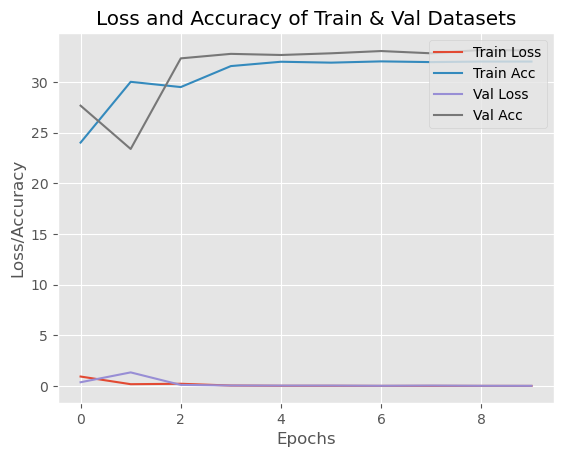

In [157]:
# Plotting the training loss and accuracy
%matplotlib inline

plt.style.use('ggplot')
plt.figure()
plt.title('Loss and Accuracy of Train & Val Datasets')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.plot(Train_val_perf_rslt['Train_loss'],label='Train Loss')
plt.plot(Train_val_perf_rslt['Train_acc'],label='Train Acc')
plt.plot(Train_val_perf_rslt['Val_loss'],label='Val Loss')
plt.plot(Train_val_perf_rslt['Val_acc'],label='Val Acc')
plt.legend(loc='upper right')
plt.show()


In [156]:
# Turning off autograd for testing evaluation
with torch.no_grad():

# setting the model in evaluation mode
    model.eval()

# initializing list to store predictions
    train_pred=[]

# looping over the test set
    for (x,y) in test_loader:
        x=x.to(device)

# making predictions and adding them to the lisy above
        pred=model(x)
        train_pred.extend(pred.argmax(axis=1).cpu().numpy())

test_targets=np.array(test_dataset.targets)
train_pred=np.array(train_pred)

# generating classification report
print(classification_report(test_targets,train_pred,target_names=test_dataset.classes))


              precision    recall  f1-score   support

   0_notflip       0.98      1.00      0.99       307
      1_flip       1.00      0.98      0.99       290

    accuracy                           0.99       597
   macro avg       0.99      0.99      0.99       597
weighted avg       0.99      0.99      0.99       597



In [ ]:
# serialize the model to disk
torch.save(model, args["LeNet_model"])

In [ ]:
if test_dataset.classes == '1_flip':
        test_dataset.class_to_idx={'1_flip':1}
elif test_dataset.classes == '0_notflip':
        test_dataset.class_to_idx={'0_notflip':0}

test_dataset.classes        


['0_notflip', '1_flip']